In [2]:
import sys
import os
import json
import pandas
import numpy as np
import optparse
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Embedding, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Input
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPooling1D, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

from collections import OrderedDict
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from google.colab import drive


In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/creditcard.csv"

In [4]:
creditcard = pandas.read_csv(path)


In [5]:
creditcard.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# **1. Feature Engineering**

In [6]:

features = creditcard.drop(columns=['Class'])

# Standard scaling of features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [7]:
X = pandas.DataFrame(scaled_features, columns=features.columns)
y = creditcard['Class']


In [8]:

#use stratification and train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
X_train.shape

(227845, 30)

In [10]:
X_test.shape

(56962, 30)

In [11]:
y_train.shape

(227845,)

In [12]:
y_test.shape

(56962,)

# **EDA**

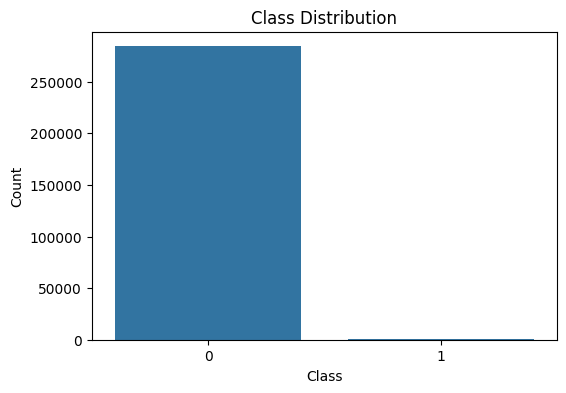

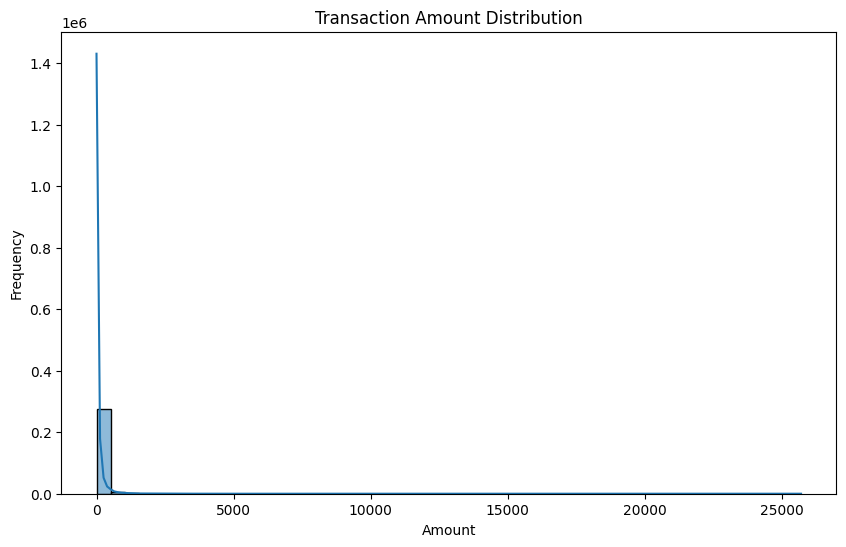

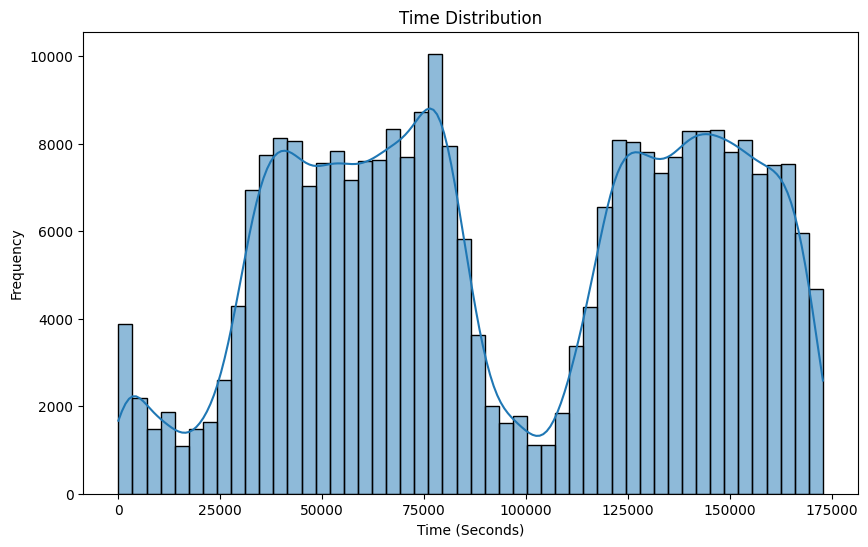

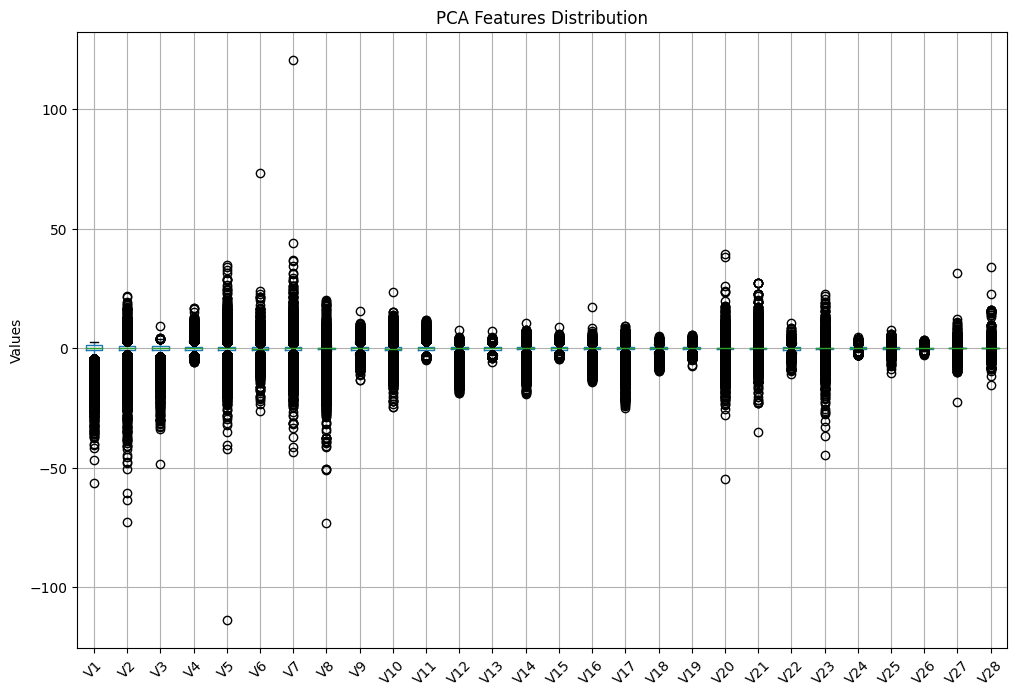

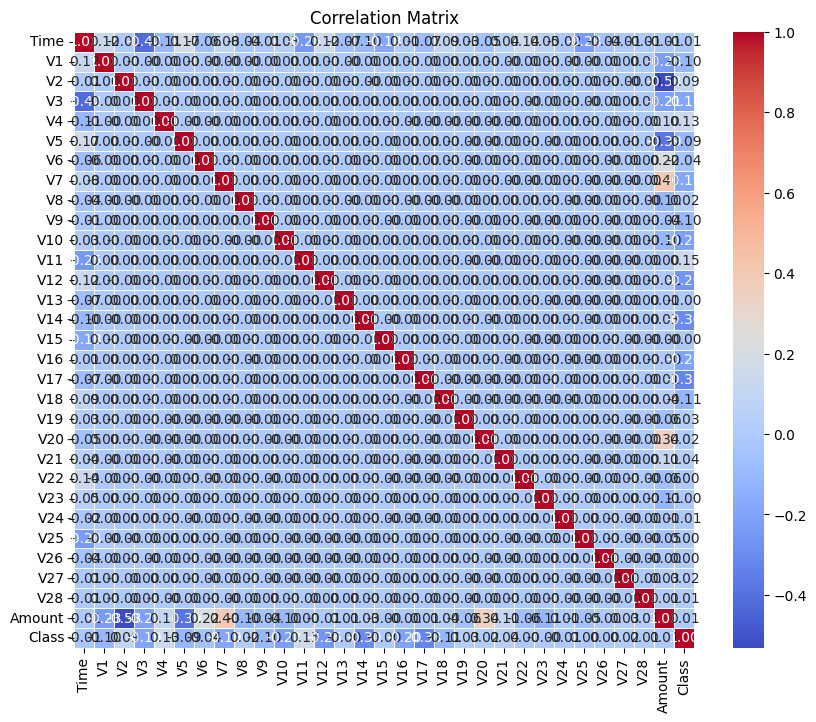

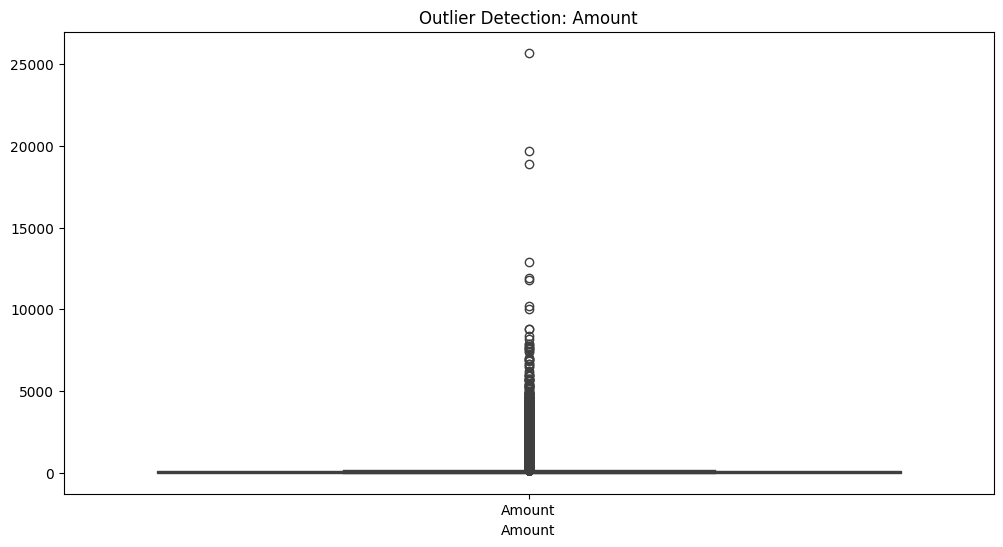

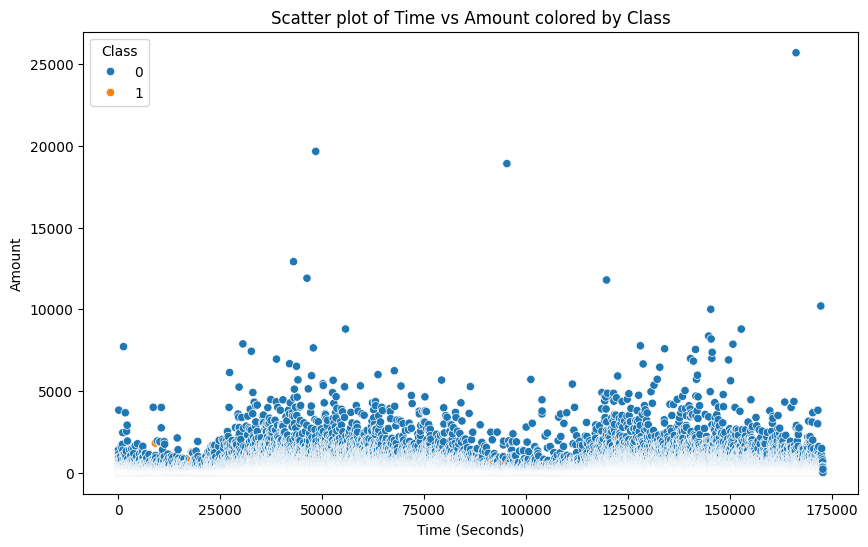

In [ ]:

# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=creditcard)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 2. Transaction Amount Distribution
plt.figure(figsize=(10, 6))
sns.histplot(creditcard['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# 3. Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(creditcard['Time'], bins=50, kde=True)
plt.title('Time Distribution')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency')
plt.show()

# 4. Principal Component Analysis (PCA) Features
pca_features = creditcard.drop(columns=['Time', 'Amount', 'Class'])
plt.figure(figsize=(12, 8))
pca_features.boxplot(rot=45)
plt.title('PCA Features Distribution')
plt.ylabel('Values')
plt.show()

# 5. Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(creditcard.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 6. Outlier Detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=creditcard[['Amount']])  # You can include other features here for outlier detection
plt.title('Outlier Detection: Amount')
plt.xlabel('Amount')
plt.show()

# 7. Visualizing Fraudulent Transactions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=creditcard)
plt.title('Scatter plot of Time vs Amount colored by Class')
plt.xlabel('Time (Seconds)')
plt.ylabel('Amount')
plt.show()




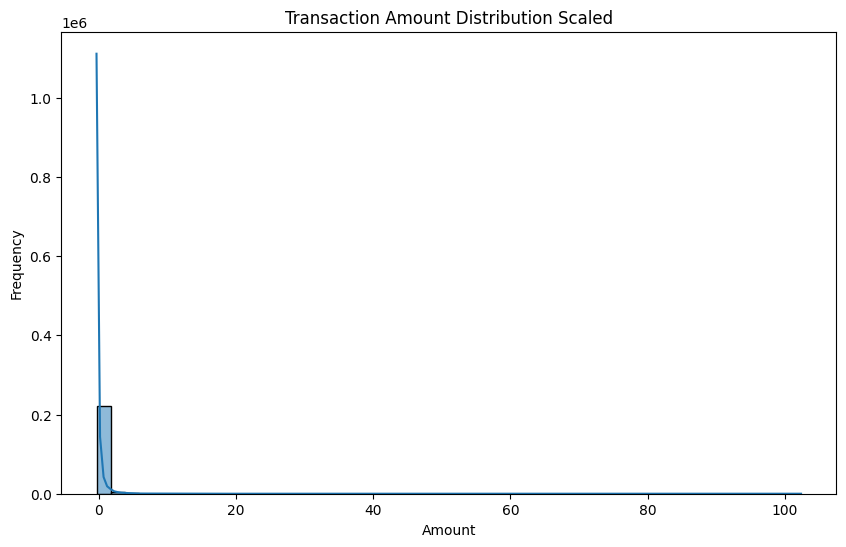

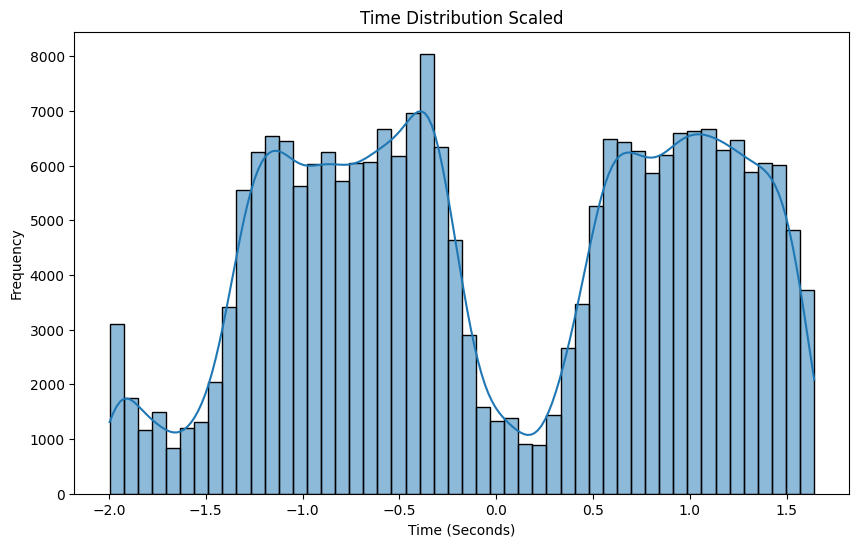

In [ ]:
# 2. Transaction Amount Distribution of train scaled
plt.figure(figsize=(10, 6))
sns.histplot(X_train['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution Scaled')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# 3. Time Distribution of train scaled
plt.figure(figsize=(10, 6))
sns.histplot(X_train['Time'], bins=50, kde=True)
plt.title('Time Distribution Scaled')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency')
plt.show()

## **Credit Card Fraud Detection Using Deep Learning**

In [13]:
#use validation split for deep learning
x_train, x_valid, Y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [14]:
Y_train.shape

(182276,)

# **Bayesian Optimization for hyperparameter tuning of Deep CNN**

Naive model:

In [18]:
import tensorflow as tf

tf.random.set_seed(42)


In [ ]:

# Define input dimensions
input_dim = 30

# Defining the search space
space = {
    'epochs': hp.choice('epochs', [10, 20, 30, 60, 90, 120]),  # Number of epochs
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),  # Dropout rate
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),  # Learning rate
    'conv_filters': hp.choice('conv_filters', [32, 64, 128, 256]),  # Number of convolutional filters
    'conv_layers': hp.choice('conv_layers', [1, 2, 3, 4]),  # Number of convolutional layers
    'hidden_units': hp.choice('hidden_units', [64, 128, 256, 512]),  # Number of dense layer units
    'hidden_layers': hp.choice('hidden_layers', [1, 2, 3, 4]),  # Number of hidden layers
    'kernel_size': hp.choice('kernel_size', [2, 3, 4, 5])  # Kernel size for Conv1D
}

def objective(params):
    epochs = params['epochs']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    conv_filters = params['conv_filters']
    conv_layers = params['conv_layers']
    hidden_units = params['hidden_units']
    hidden_layers = params['hidden_layers']
    kernel_size = params['kernel_size']


    model = Sequential(name="Custom_Conv_Model")
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    for _ in range(conv_layers - 1):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())

    for _ in range(hidden_layers):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

#Model evaluation
    y_pred = model.predict(X_test).flatten()
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr = auc(recall, precision)

    return {'loss': -auc_pr, 'status': STATUS_OK, 'model': model, 'history': history}

# Using 5 trials, perform Bayesian optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=5, trials=trials)

# Storing the optimal hyperparameters
best_epochs = [10, 20, 30, 60, 90, 120][best['epochs']]
best_dropout_rate = best['dropout_rate']
best_learning_rate = best['learning_rate']
best_conv_filters = [32, 64, 128, 256][best['conv_filters']]
best_conv_layers = [1, 2, 3, 4][best['conv_layers']]
best_hidden_units = [64, 128, 256, 512][best['hidden_units']]
best_hidden_layers = [1, 2, 3, 4][best['hidden_layers']]
best_kernel_size = [2, 3, 4, 5][best['kernel_size']]

print("Best Hyperparameters:")
print("Epochs:", best_epochs)
print("Dropout Rate:", best_dropout_rate)
print("Learning Rate:", best_learning_rate)
print("Convolutional Filters:", best_conv_filters)
print("Convolutional Layers:", best_conv_layers)
print("Hidden Units:", best_hidden_units)
print("Hidden Layers:", best_hidden_layers)
print("Kernel Size:", best_kernel_size)

#defining best hytperparameters
hyperparameters = {
    "Epochs": best_epochs,
    "Dropout Rate": best_dropout_rate,
    "Learning Rate": best_learning_rate,
    "Convolutional Filters": best_conv_filters,
    "Convolutional Layers": best_conv_layers,
    "Hidden Units": best_hidden_units,
    "Hidden Layers": best_hidden_layers,
    "Kernel Size": best_kernel_size
}


Streaming output truncated to the last 5000 lines.
3561/3561 [==============================] - 76s 21ms/step - loss: 0.0127 - val_loss: 0.0128

Epoch 7/10

3561/3561 [==============================] - 75s 21ms/step - loss: 0.0128 - val_loss: 0.0128

Epoch 8/10

3561/3561 [==============================] - 75s 21ms/step - loss: 0.0128 - val_loss: 0.0128

Epoch 9/10

3561/3561 [==============================] - 75s 21ms/step - loss: 0.0128 - val_loss: 0.0128

Epoch 10/10

3561/3561 [==============================] - 75s 21ms/step - loss: 0.0128 - val_loss: 0.0128

1781/1781 [==============================] - 9s 5ms/step

100%|██████████| 5/5 [1:06:03<00:00, 792.72s/trial, best loss: -0.7777378992784021]
Best Hyperparameters:
Epochs: 90
Dropout Rate: 0.4228662913853429
Learning Rate: 0.00022750217423220872
Convolutional Filters: 64
Convolutional Layers: 3
Hidden Units: 128
Hidden Layers: 2
Kernel Size: 4


In [ ]:
print(best_epochs)

90


In [19]:
#manually storing best hyperparamaters to avoid having to rerun bayesian optimization each time
best_epochs = 90
best_dropout_rate = 0.4228662913853429
best_kernel_size = 4
best_hidden_layers = 2
best_conv_filters = 64
best_conv_layers = 3
best_hidden_units = 128
best_learning_rate = 0.00022750217423220872

**Building Simple CNN using ebst hyperparameters**

In [20]:
input_dim = 30

cnn_model_two = Sequential()
cnn_model_two.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
cnn_model_two.add(Conv1D(filters=best_conv_filters, kernel_size=best_kernel_size, activation='relu', padding='same'))
cnn_model_two.add(MaxPooling1D(pool_size=2))
cnn_model_two.add(Dropout(best_dropout_rate))

for _ in range(best_conv_layers - 1):
    cnn_model_two.add(Conv1D(filters=best_conv_filters, kernel_size=best_kernel_size, activation='relu', padding='same'))
    cnn_model_two.add(MaxPooling1D(pool_size=2))
    cnn_model_two.add(Dropout(best_dropout_rate))

cnn_model_two.add(Flatten())

for _ in range(best_hidden_layers):
    cnn_model_two.add(Dense(best_hidden_units, activation='relu', kernel_regularizer=l2(0.01)))
    cnn_model_two.add(Dropout(best_dropout_rate))

cnn_model_two.add(Dense(1, activation='sigmoid'))

cnn_model_two.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_two = cnn_model_two.fit(X_train, y_train, epochs=best_epochs, batch_size=64, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

y_pred_test = cnn_model_two.predict(X_test).flatten()
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_test)
auc_pr_test = auc(recall_test, precision_test)
print("Test AUC PR:", auc_pr_test)

y_pred_train = cnn_model_two.predict(X_train).flatten()
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train)
auc_pr_train = auc(recall_train, precision_train)
print("Train AUC PR:", auc_pr_train)


Epoch 1/90
3561/3561 [==============================] - 30s 8ms/step - loss: 0.2428 - val_loss: 0.0098
Epoch 2/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 3/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 4/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 5/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 6/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 7/90
3561/3561 [==============================] - 29s 8ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 8/90
3561/3561 [==============================] - 28s 8ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 9/90
3561/3561 [==============================] - 28s 8ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 10/90
3561/3561 [==============================] - 28s 8ms/step - l

In [21]:
print("Test precision:", precision_test)
print("Test recall:", recall_test)
print("Train precision:", precision_train)
print("Train recall:", recall_train)


Test precision: [0.00172045 0.00172048 0.00172051 ... 0.83516484 0.84444444 1.        ]
Test recall: [1.        1.        1.        ... 0.7755102 0.7755102 0.       ]
Train precision: [0.00172925 0.00172925 0.00172926 ... 0.88888889 0.88855422 1.        ]
Train recall: [1.         1.         1.         ... 0.75126904 0.74873096 0.        ]


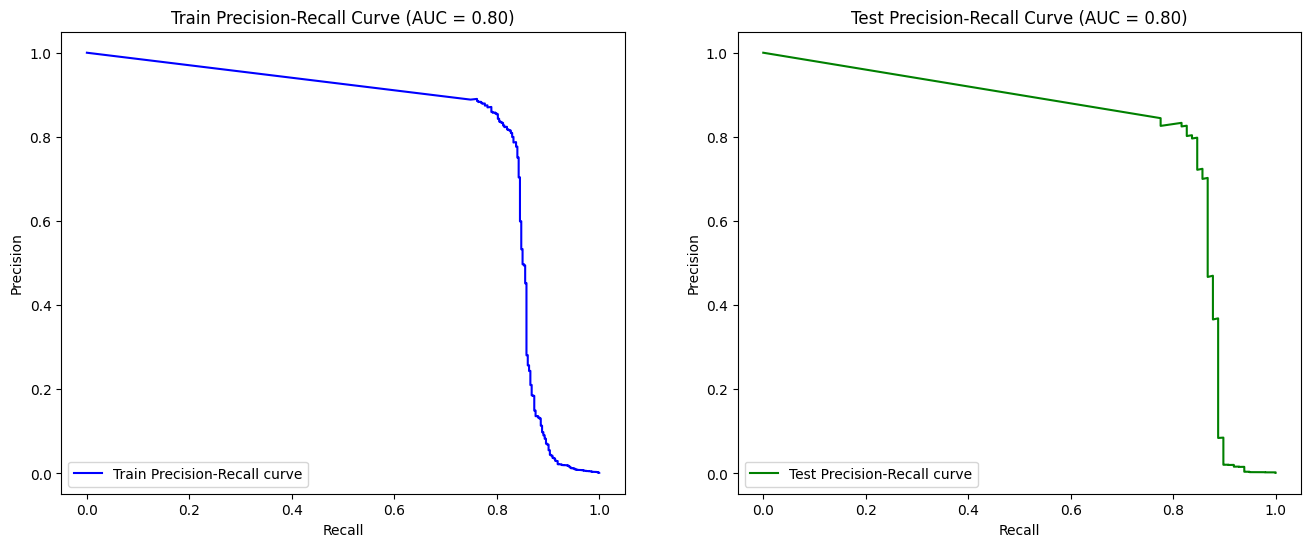

In [22]:
# Plotting precision-recall curve for train and test with AUC
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_train, precision_train, color='blue', label='Train Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train Precision-Recall Curve (AUC = %0.2f)' % auc_pr_train)
plt.legend(loc="lower left")

plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='green', label='Test Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Precision-Recall Curve (AUC = %0.2f)' % auc_pr_test)
plt.legend(loc="lower left")

plt.show()




In [23]:
#converting predictions using a threshold of .5 to get in to binary format
threshold = 0.5

y_pred_train_binary = (y_pred_train >= threshold).astype(int)
y_pred_test_binary = (y_pred_test >= threshold).astype(int)

# Using confusion matrix for train predictions
train_conf_matrix = confusion_matrix(y_train, y_pred_train_binary)
tn_train, fp_train, fn_train, tp_train = train_conf_matrix.ravel()

# Calculate false positive rate and false negative rate as percentages for train predictions
fpr_train_percent = (fp_train / (fp_train + tp_train)) * 100
fnr_train_percent = (fn_train / (fn_train + tp_train)) * 100

print("Train False Positive Rate (as percentage of predicted positives):", fpr_train_percent)
print("Train False Negative Rate (as percentage of true positives):", fnr_train_percent)
train_conf_matrix = confusion_matrix(y_train, y_pred_train_binary)
tn_test, fp_test, fn_test, tp_test = train_conf_matrix.ravel()


fpr_test_percent = (fp_test / (fp_test + tp_test)) * 100
fnr_test_percent = (fn_test / (fn_test + tp_test)) * 100

print("Test False Positive Rate (as percentage of predicted positives):", fpr_test_percent)
print("Test False Negative Rate (as percentage of true positives):", fnr_test_percent)


Train False Positive Rate (as percentage of predicted positives): 14.049586776859504
Train False Negative Rate (as percentage of true positives): 20.812182741116754
Test False Positive Rate (as percentage of predicted positives): 14.049586776859504
Test False Negative Rate (as percentage of true positives): 20.812182741116754


In [ ]:
print(y_pred_train)

[7.9903555e-05 7.1381633e-05 4.6817635e-04 ... 3.5418107e-05 6.9355767e-05
 1.1455140e-04]


In [24]:

precision_train = precision_score(y_train, y_pred_train_binary)
recall_train = recall_score(y_train, y_pred_train_binary)

print("Train Precision:", precision_train)
print("Train Recall:", recall_train)

precision_test = precision_score(y_test, y_pred_test_binary)
recall_test = recall_score(y_test, y_pred_test_binary)

print("Test Precision:", precision_test)
print("Test Recall:", recall_test)


Train Precision: 0.859504132231405
Train Recall: 0.7918781725888325
Test Precision: 0.826530612244898
Test Recall: 0.826530612244898


# **DEEP MLP**

In [ ]:

input_dim = 30

space_mlp = {
    'epochs': hp.choice('epochs', [10, 20, 30, 60, 90, 120]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'hidden_units': hp.choice('hidden_units', [64, 128, 256, 512]),
    'hidden_layers': hp.choice('hidden_layers', [1, 2, 3, 4]),
}

def objective_mlp(params):
    epochs = params['epochs']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    hidden_units = params['hidden_units']
    hidden_layers = params['hidden_layers']

    mlp_model = Sequential(name="Custom_MLP_Model")
    mlp_model.add(Dense(hidden_units, activation='relu', input_shape=(input_dim,)))
    mlp_model.add(Dropout(dropout_rate))

    for _ in range(hidden_layers - 1):
        mlp_model.add(Dense(hidden_units, activation='relu'))
        mlp_model.add(Dropout(dropout_rate))

    mlp_model.add(Dense(1, activation='sigmoid'))

    mlp_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mlp_history = mlp_model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

    y_pred = mlp_model.predict(X_test).flatten()
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr = auc(recall, precision)

    return {'loss': -auc_pr, 'status': STATUS_OK, 'model': mlp_model, 'history': mlp_history}

trials_mlp = Trials()
best_mlp = fmin(objective_mlp, space_mlp, algo=tpe.suggest, max_evals=5, trials=trials_mlp)

best_mlp_epochs = [10, 20, 30, 60, 90, 120][best_mlp['epochs']]
best_mlp_dropout_rate = best_mlp['dropout_rate']
best_mlp_learning_rate = best_mlp['learning_rate']
best_mlp_hidden_units = [64, 128, 256, 512][best_mlp['hidden_units']]
best_mlp_hidden_layers = [1, 2, 3, 4][best_mlp['hidden_layers']]

print("Best Hyperparameters for MLP:")
print("Epochs:", best_mlp_epochs)
print("Dropout Rate:", best_mlp_dropout_rate)
print("Learning Rate:", best_mlp_learning_rate)
print("Hidden Units:", best_mlp_hidden_units)
print("Hidden Layers:", best_mlp_hidden_layers)

mlp_hyperparameters = {
    "Epochs": best_mlp_epochs,
    "Dropout Rate": best_mlp_dropout_rate,
    "Learning Rate": best_mlp_learning_rate,
    "Hidden Units": best_mlp_hidden_units,
    "Hidden Layers": best_mlp_hidden_layers
}


Streaming output truncated to the last 5000 lines.
3561/3561 [==============================] - 38s 11ms/step - loss: 0.0075 - val_loss: 0.0042

Epoch 30/60

3561/3561 [==============================] - 39s 11ms/step - loss: 0.0112 - val_loss: 0.0156

Epoch 31/60

3561/3561 [==============================] - 38s 11ms/step - loss: 0.0133 - val_loss: 0.0060

Epoch 32/60

3561/3561 [==============================] - 39s 11ms/step - loss: 0.0099 - val_loss: 0.0031

Epoch 33/60

3561/3561 [==============================] - 39s 11ms/step - loss: 0.0098 - val_loss: 0.0333

Epoch 34/60

3561/3561 [==============================] - 38s 11ms/step - loss: 0.0373 - val_loss: 0.0037

1781/1781 [==============================] - 5s 3ms/step

Epoch 1/10

3561/3561 [==============================] - 12s 3ms/step - loss: 0.0564 - val_loss: 0.0135

Epoch 2/10

3561/3561 [==============================] - 10s 3ms/step - loss: 0.0181 - val_loss: 0.0153

Epoch 3/10

3561/3561 [=============================

In [27]:
best_mlp_hidden_units = 128
best_mlp_hidden_layers = 3
best_mlp_dropout_rate = .3273314536394344
best_mlp_epochs = 30
best_mlp_learning_rate = 0.00026910834147924744

In [28]:
mlp_model = Sequential()
mlp_model.add(Dense(best_mlp_hidden_units, activation='relu', input_shape=(input_dim,)))
mlp_model.add(Dropout(best_mlp_dropout_rate))

for _ in range(best_mlp_hidden_layers - 1):
    mlp_model.add(Dense(best_mlp_hidden_units, activation='relu'))
    mlp_model.add(Dropout(best_mlp_dropout_rate))

mlp_model.add(Dense(1, activation='sigmoid'))

mlp_model.compile(optimizer=Adam(learning_rate=best_mlp_learning_rate), loss='binary_crossentropy')

early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp_history = mlp_model.fit(X_train, y_train, epochs=best_mlp_epochs, batch_size=64, validation_split=0.1, callbacks=[early_stopping_mlp])

y_pred_test_mlp = mlp_model.predict(X_test).flatten()
precision_test_mlp, recall_test_mlp, _ = precision_recall_curve(y_test, y_pred_test_mlp)
auc_pr_test_mlp = auc(recall_test_mlp, precision_test_mlp)
print("Test AUC PR (MLP):", auc_pr_test_mlp)

y_pred_train_mlp = mlp_model.predict(X_train).flatten()
precision_train_mlp, recall_train_mlp, _ = precision_recall_curve(y_train, y_pred_train_mlp)
auc_pr_train_mlp = auc(recall_train_mlp, precision_train_mlp)
print("Train AUC PR (MLP):", auc_pr_train_mlp)


Epoch 1/30
3205/3205 [==============================] - 9s 2ms/step - loss: 0.0161 - val_loss: 0.0025
Epoch 2/30
3205/3205 [==============================] - 7s 2ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 3/30
3205/3205 [==============================] - 8s 2ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/30
3205/3205 [==============================] - 8s 2ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/30
3205/3205 [==============================] - 8s 2ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 6/30
3205/3205 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/30
3205/3205 [==============================] - 7s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 8/30
3205/3205 [==============================] - 7s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/30
3205/3205 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/30
3205/3205 [==============================] - 8s 2ms/step - loss: 0.002

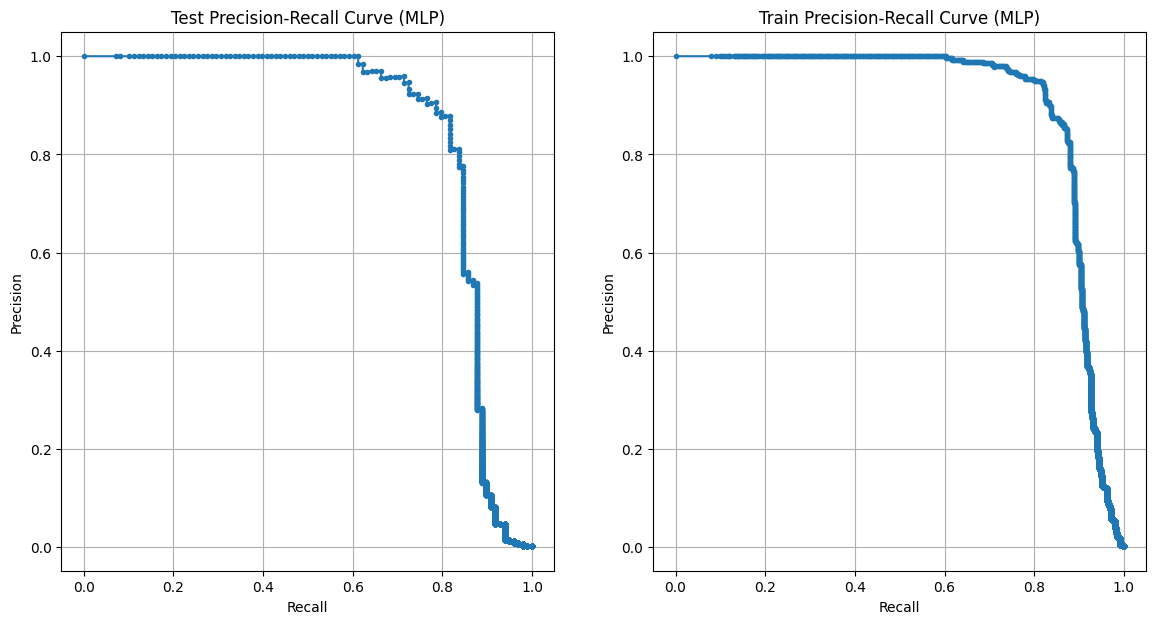

In [29]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(recall_test_mlp, precision_test_mlp, marker='.')
plt.title('Test Precision-Recall Curve (MLP)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall_train_mlp, precision_train_mlp, marker='.')
plt.title('Train Precision-Recall Curve (MLP)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.show()


In [30]:

threshold = 0.5

y_pred_train_mlp_binary = (y_pred_train_mlp >= threshold).astype(int)
y_pred_test_mlp_binary = (y_pred_test_mlp >= threshold).astype(int)

train_conf_matrix_mlp = confusion_matrix(y_train, y_pred_train_mlp_binary)
tn_train_mlp, fp_train_mlp, fn_train_mlp, tp_train_mlp = train_conf_matrix_mlp.ravel()

fpr_train_mlp_percent = (fp_train_mlp / (fp_train_mlp + tp_train_mlp)) * 100
fnr_train_mlp_percent = (fn_train_mlp / (fn_train_mlp + tp_train_mlp)) * 100

print("Train False Positive Rate (MLP) (as percentage of predicted positives):", fpr_train_mlp_percent)
print("Train False Negative Rate (MLP) (as percentage of true positives):", fnr_train_mlp_percent)

test_conf_matrix_mlp = confusion_matrix(y_test, y_pred_test_mlp_binary)
tn_test_mlp, fp_test_mlp, fn_test_mlp, tp_test_mlp = test_conf_matrix_mlp.ravel()

fpr_test_mlp_percent = (fp_test_mlp / (fp_test_mlp + tp_test_mlp)) * 100
fnr_test_mlp_percent = (fn_test_mlp / (fn_test_mlp + tp_test_mlp)) * 100

print("Test False Positive Rate (MLP) (as percentage of predicted positives):", fpr_test_mlp_percent)
print("Test False Negative Rate (MLP) (as percentage of true positives):", fnr_test_mlp_percent)

precision_train_mlp_binary = precision_score(y_train, y_pred_train_mlp_binary)
recall_train_mlp_binary = recall_score(y_train, y_pred_train_mlp_binary)

print("Train Precision (MLP):", precision_train_mlp_binary)
print("Train Recall (MLP):", recall_train_mlp_binary)



Train False Positive Rate (MLP) (as percentage of predicted positives): 9.392265193370166
Train False Negative Rate (MLP) (as percentage of true positives): 16.751269035532996
Test False Positive Rate (MLP) (as percentage of predicted positives): 19.0
Test False Negative Rate (MLP) (as percentage of true positives): 17.346938775510203
Train Precision (MLP): 0.9060773480662984
Train Recall (MLP): 0.8324873096446701


In [31]:
precision_test_mlp_binary = precision_score(y_test, y_pred_test_mlp_binary)
recall_test_mlp_binary = recall_score(y_test, y_pred_test_mlp_binary)

print("Test Precision (MLP):", precision_test_mlp_binary)
print("Test Recall (MLP):", recall_test_mlp_binary)


Test Precision (MLP): 0.81
Test Recall (MLP): 0.826530612244898


# **RNN**

In [32]:
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)
X_train_reshaped, X_valid_reshaped, y_train, y_valid = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)


In [ ]:

max_log_length = 30

space_rnn = {
    'epochs': hp.choice('epochs', [3,5,10]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),  =
    'lstm_units': hp.choice('lstm_units', [32, 64, 128]),
}

def objective_rnn(params):
    epochs = params['epochs']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    lstm_units = params['lstm_units']

    model_rnn_advanced = Sequential()
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(max_log_length, 1))))
    model_rnn_advanced.add(Dropout(dropout_rate))
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate)))
    model_rnn_advanced.add(Dense(units=32, activation='relu'))
    model_rnn_advanced.add(Dense(units=16, activation='relu'))
    model_rnn_advanced.add(Dense(units=1, activation='sigmoid'))

    model_rnn_advanced.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    rnn_history = model_rnn_advanced.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=64, validation_data=(X_valid_reshaped, y_valid), callbacks=[early_stopping])

    y_pred = model_rnn_advanced.predict(X_test_reshaped).flatten()
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr = auc(recall, precision)

    return {'loss': -auc_pr, 'status': STATUS_OK, 'model': model_rnn_advanced, 'history': rnn_history}

trials_rnn = Trials()
best_rnn = fmin(objective_rnn, space_rnn, algo=tpe.suggest, max_evals=5, trials=trials_rnn)

best_rnn_epochs = [3,5,10][best_rnn['epochs']]
best_rnn_dropout_rate = best_rnn['dropout_rate']
best_rnn_learning_rate = best_rnn['learning_rate']
best_rnn_lstm_units = [32, 64, 128][best_rnn['lstm_units']]

print("Best Hyperparameters for RNN:")
print("Epochs:", best_rnn_epochs)
print("Dropout Rate:", best_rnn_dropout_rate)
print("Learning Rate:", best_rnn_learning_rate)
print("LSTM Units:", best_rnn_lstm_units)

rnn_hyperparameters = {
    "Epochs": best_rnn_epochs,
    "Dropout Rate": best_rnn_dropout_rate,
    "Learning Rate": best_rnn_learning_rate,
    "LSTM Units": best_rnn_lstm_units
}



Streaming output truncated to the last 5000 lines.
2849/2849 [==============================] - 174s 61ms/step - loss: 0.0052 - val_loss: 0.0048

Epoch 3/3

2849/2849 [==============================] - 173s 61ms/step - loss: 0.0046 - val_loss: 0.0061

1781/1781 [==============================] - 25s 14ms/step

100%|██████████| 5/5 [1:20:08<00:00, 961.65s/trial, best loss: -0.8196308846467912]
Best Hyperparameters for RNN:
Epochs: 10
Dropout Rate: 0.29936428578875957
Learning Rate: 0.0004355141629928943
LSTM Units: 64


In [33]:
max_log_length = 30

def build_rnn_model(dropout_rate, learning_rate, lstm_units):
    model_rnn_advanced = Sequential()
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(max_log_length, 1))))
    model_rnn_advanced.add(Dropout(dropout_rate))
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate)))
    model_rnn_advanced.add(Dense(units=32, activation='relu'))
    model_rnn_advanced.add(Dense(units=16, activation='relu'))
    model_rnn_advanced.add(Dense(units=1, activation='sigmoid'))
    model_rnn_advanced.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
    return model_rnn_advanced

best_rnn_epochs = 10
best_rnn_dropout_rate = 0.29936428578875957
best_rnn_learning_rate = 0.0004355141629928943
best_rnn_lstm_units = 64

In [ ]:
max_log_length = 30

def build_rnn_model(dropout_rate, learning_rate, lstm_units):
    model_rnn_advanced = Sequential()
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(max_log_length, 1))))
    model_rnn_advanced.add(Dropout(dropout_rate))
    model_rnn_advanced.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout=dropout_rate)))
    model_rnn_advanced.add(Dense(units=32, activation='relu'))
    model_rnn_advanced.add(Dense(units=16, activation='relu'))
    model_rnn_advanced.add(Dense(units=1, activation='sigmoid'))
    model_rnn_advanced.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
    return model_rnn_advanced

best_rnn_epochs = rnn_hyperparameters["Epochs"]
best_rnn_dropout_rate = rnn_hyperparameters["Dropout Rate"]
best_rnn_learning_rate = rnn_hyperparameters["Learning Rate"]
best_rnn_lstm_units = rnn_hyperparameters["LSTM Units"]

Epoch 1/10
2849/2849 [==============================] - 189s 63ms/step - loss: 0.0094 - val_loss: 0.0041
Epoch 2/10
2849/2849 [==============================] - 179s 63ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 3/10
2849/2849 [==============================] - 180s 63ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 4/10
2849/2849 [==============================] - 179s 63ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 5/10
2849/2849 [==============================] - 180s 63ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/10
2849/2849 [==============================] - 180s 63ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 7/10
2849/2849 [==============================] - 179s 63ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 8/10
2849/2849 [==============================] - 180s 63ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 9/10
2849/2849 [==============================] - 179s 63ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/10
1781/1781 [==============================] 

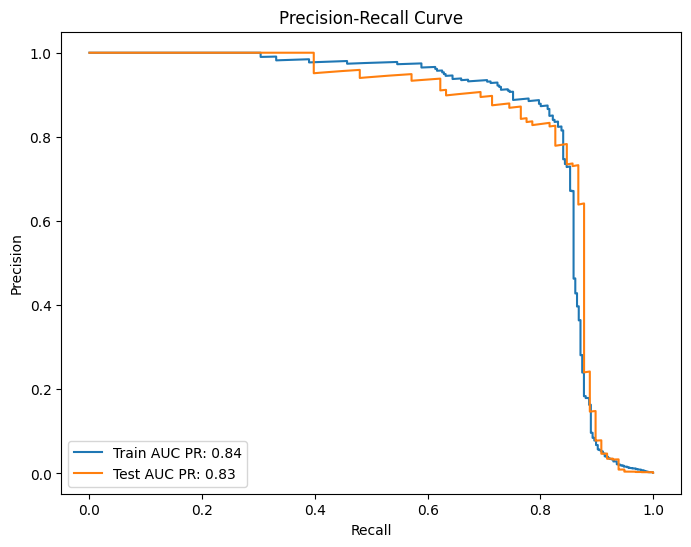

In [34]:

best_model_rnn = build_rnn_model(best_rnn_dropout_rate, best_rnn_learning_rate, best_rnn_lstm_units)

best_model_rnn.fit(X_train_reshaped, y_train, epochs=best_rnn_epochs, batch_size=64, validation_data=(X_valid_reshaped, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

train_predictions = best_model_rnn.predict(X_train_reshaped).flatten()
precision_train, recall_train, _ = precision_recall_curve(y_train, train_predictions)
auc_pr_train = auc(recall_train, precision_train)

test_predictions = best_model_rnn.predict(X_test_reshaped).flatten()
precision_test, recall_test, _ = precision_recall_curve(y_test, test_predictions)
auc_pr_test = auc(recall_test, precision_test)

plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Train AUC PR: {auc_pr_train:.2f}')
plt.plot(recall_test, precision_test, label=f'Test AUC PR: {auc_pr_test:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


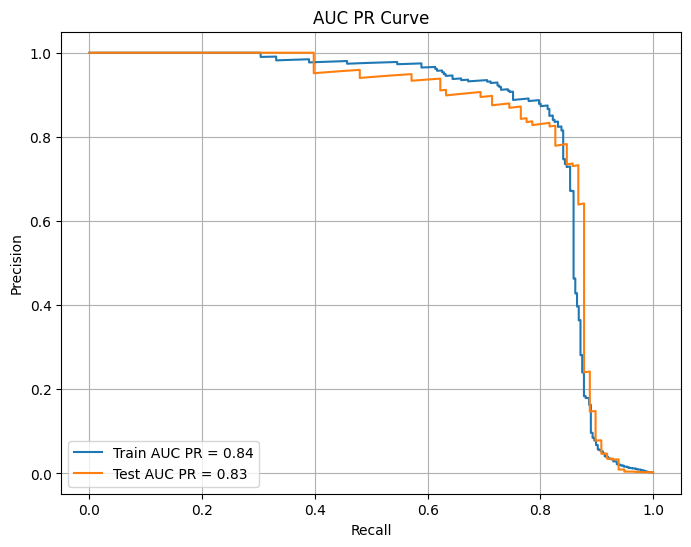

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Train AUC PR = {auc_pr_train:.2f}')
plt.plot(recall_test, precision_test, label=f'Test AUC PR = {auc_pr_test:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUC PR Curve')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

threshold = 0.5

train_predictions_binary = (train_predictions >= threshold).astype(int)
test_predictions_binary = (test_predictions >= threshold).astype(int)

train_conf_matrix_rnn = confusion_matrix(y_train, train_predictions_binary)
tn_train_rnn, fp_train_rnn, fn_train_rnn, tp_train_rnn = train_conf_matrix_rnn.ravel()

fpr_train_rnn_percent = (fp_train_rnn / (fp_train_rnn + tp_train_rnn)) * 100
fnr_train_rnn_percent = (fn_train_rnn / (fn_train_rnn + tp_train_rnn)) * 100

print("Train False Positive Rate (RNN) (as percentage of predicted positives):", fpr_train_rnn_percent)
print("Train False Negative Rate (RNN) (as percentage of true positives):", fnr_train_rnn_percent)

test_conf_matrix_rnn = confusion_matrix(y_test, test_predictions_binary)
tn_test_rnn, fp_test_rnn, fn_test_rnn, tp_test_rnn = test_conf_matrix_rnn.ravel()

fpr_test_rnn_percent = (fp_test_rnn / (fp_test_rnn + tp_test_rnn)) * 100
fnr_test_rnn_percent = (fn_test_rnn / (fn_test_rnn + tp_test_rnn)) * 100

print("Test False Positive Rate (RNN) (as percentage of predicted positives):", fpr_test_rnn_percent)
print("Test False Negative Rate (RNN) (as percentage of true positives):", fnr_test_rnn_percent)

precision_train_rnn_binary = precision_score(y_train, train_predictions_binary)
recall_train_rnn_binary = recall_score(y_train, train_predictions_binary)

print("Train Precision (RNN):", precision_train_rnn_binary)
print("Train Recall (RNN):", recall_train_rnn_binary)

precision_test_rnn_binary = precision_score(y_test, test_predictions_binary)
recall_test_rnn_binary = recall_score(y_test, test_predictions_binary)

print("Test Precision (RNN):", precision_test_rnn_binary)
print("Test Recall (RNN):", recall_test_rnn_binary)


Train False Positive Rate (RNN) (as percentage of predicted positives): 7.782101167315175
Train False Negative Rate (RNN) (as percentage of true positives): 27.300613496932513
Test False Positive Rate (RNN) (as percentage of predicted positives): 10.256410256410255
Test False Negative Rate (RNN) (as percentage of true positives): 28.57142857142857
Train Precision (RNN): 0.9221789883268483
Train Recall (RNN): 0.7269938650306749
Test Precision (RNN): 0.8974358974358975
Test Recall (RNN): 0.7142857142857143
